In [35]:
import sys
sys.path.append('../')

import os
from pathlib import Path
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import iplot
import numpy as np

%load_ext autoreload
%autoreload 2
from _util.make_folder_dataset import MakeFolderDataset


#load environment variables from .env file in repo root
%load_ext dotenv
%dotenv

#DATASET_REPO_ROOT_PATH=<absolute-path-to-dataset-repo-root-folder>
dataset_repo_root_path = Path(os.environ.get("DATASET_REPO_ROOT_PATH"))
test_data_path = dataset_repo_root_path / "testData" / "online"

labels_map = {'hard':0,'pvc_tube':1, 'soft':2}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [36]:
def get_next_contact_time(df, excl_from_time):
    # first_no_contact_time = df[df['has_contact'] == 0].iloc[0]['time']
    filtered_df = df[(df['time'] > excl_from_time) & (df['has_contact'] == 1)]
    return (filtered_df.iloc[0]['time'], filtered_df.index[0]) if len(filtered_df) > 0 else (None, None)


def get_contact_duration(df, time):
    try:
        start_time_index = df[(df['time'] < time) & (
            df['has_contact'] == 0)].index[-1] + 1
    except IndexError:
        start_time_index = 0
    start_time = df.loc[start_time_index, 'time']
    try:
        end_time_index = df[(df['time'] > time) & (
            df['has_contact'] == 0)].index[0] - 1
    except IndexError:
        # occurs if filtered df above is empty, which means there is no row with has_contact = 0 after specified time
        end_time_index = df.index[-1]
    end_time = df.loc[end_time_index, 'time']
    return (end_time - start_time), start_time, end_time


def evaluation(inst: MakeFolderDataset):
    first_prediction_after_contact_indices = []
    last_contact_end_time = -1
    while True:
        contact_time, _ = get_next_contact_time(
            inst.model_results, last_contact_end_time)
        if contact_time is None:
            break
        _, _, last_contact_end_time = get_contact_duration(
            inst.model_results, contact_time)
        try:
            idx = inst.model_results[(inst.model_results['time'] >= contact_time) &
                                     (inst.model_results["contact_class_prediction"].notna())].index[0]
        except:
            idx = None
        if idx is not None:
            first_prediction_after_contact_indices.append(idx)

    first_predictions_after_contact = inst.model_results.iloc[
        first_prediction_after_contact_indices].drop_duplicates()
    
    # randomly sample 3 predictions from instance, such that the evaluated samples are balanced acrross the classes and motions
    # (3 is the min. number of predictions over all instances)
    first_predictions_after_contact = first_predictions_after_contact.sample(n=3)

    first_predictions_accuracy = first_predictions_after_contact['correctly_classified'].mean(
    )

    print(inst.name)
    print(
        f"Accuracy of first predictions after contact: {first_predictions_accuracy * 100:.2f}% ({len(first_predictions_after_contact)} predictions)\n")

    '''trace1 = go.Scatter(
        x=inst.true_label['time'], y=inst.true_label['has_contact'], name='contact')
    trace2 = go.Scatter(
        x=first_predictions_after_contact['time'], y=first_predictions_after_contact['correctly_classified'], name='prediction correctness', mode="markers",
        marker=dict(color=['red' if x == 0 else '#77DD77' for x in first_predictions_after_contact['correctly_classified']]))
    trace3 = go.Scatter(
        x=first_predictions_after_contact['time'], y=first_predictions_after_contact[
            'contact_class_prediction'], name=f"prediction<br>({str(labels_map)})",
        mode="markers", marker=dict(color="#aaaaaa"))
    data = [trace1, trace3, trace2]
    layout = go.Layout(title=f'(instance {inst.name})',
                       xaxis=dict(title='time(sec)'),
                       yaxis=dict(title='Y-axis'))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)'''

    num_correctly_classified = first_predictions_after_contact[
        first_predictions_after_contact['correctly_classified'] == 1].shape[0]
    return first_predictions_after_contact.shape[0], num_correctly_classified, first_predictions_after_contact

In [37]:
instances: list[tuple[Path, MakeFolderDataset]] = []
for p in test_data_path.iterdir():
    if p.is_dir() and p.name != "_ignore" and p.name.startswith("Transformer_sliding_left_offset15ms_step1"):
        instance = MakeFolderDataset(p.absolute())
        instance.extract_robot_data()
        instance.get_labels_all()

        instance.model_results = pd.read_csv(
            str((p / "model_result.csv").absolute()), header=None, skiprows=1).iloc[:, :5]
        headers = ["Time_sec", "Time_nsec", "prediction_duration",
                   "contact", "contact_class_prediction"]
        instance.model_results.columns = headers

        instance.model_results['time'] = instance.model_results['Time_sec'] + \
            instance.model_results['Time_nsec'] - instance.init_time

        instance.true_label.rename(
            columns={"DATA0": "has_contact"}, inplace=True)
        instance.true_label = instance.true_label[["time", "has_contact"]]

        # Merge model results insto sensor data time-series (true_label) -> time-series of contact/no-contact with contact class predictions
        instance.model_results = pd.merge(
            instance.true_label, instance.model_results, on='time', how='outer')
        instance.model_results['has_contact'] = instance.model_results['has_contact'].fillna(
            1)

        instance.model_results['correctly_classified'] = np.where(
            instance.model_results['contact_class_prediction'].isna(),
            np.nan,
            np.where(
                instance.model_results['has_contact'] == 1,
                np.where(instance.model_results['contact_class_prediction']
                         == labels_map[instance.contact_type], 1, 0),
                np.nan
            )
        )

        instances.append(instance)

all_predictions = pd.DataFrame()
all_predictions_per_model = {
    "GRUModel": (0, 0),
    "LSTMModel": (0, 0),
    "Transformer": (0, 0)
}

instances = sorted(instances, key=lambda i: i.name)
for inst in instances:
    num_predictions, num_correct_predictions, inst_predictions = evaluation(inst)
    
    model_type = inst.name.split("_")[0]
    all_predictions_per_model[model_type] = (all_predictions_per_model[model_type][0] + num_predictions,
                                             all_predictions_per_model[model_type][1] + num_correct_predictions)
    
    inst_predictions = inst_predictions[["prediction_duration", "contact_class_prediction", "correctly_classified"]].copy()
    inst_predictions["instance"] = inst.name
    inst_predictions["contact_class"] = labels_map[inst.contact_type]
    all_predictions = pd.concat([all_predictions, inst_predictions])

print()
for k, v in all_predictions_per_model.items():
    try:
        print(
            f"{k}: Accuracy: {v[1]/v[0]*100:.2f}% ({v[0]} predictions, {v[1]} correct predictions)")
    except ZeroDivisionError:
        print("zero division error - no predictions")

Transformer_sliding_left_offset15ms_step1_HV15_a2_hard
Accuracy of first predictions after contact: 100.00% (3 predictions)

Transformer_sliding_left_offset15ms_step1_HV15_a2_hard_2
Accuracy of first predictions after contact: 100.00% (3 predictions)

Transformer_sliding_left_offset15ms_step1_HV15_a2_pvc
Accuracy of first predictions after contact: 100.00% (3 predictions)

Transformer_sliding_left_offset15ms_step1_HV15_a2_pvc_2
Accuracy of first predictions after contact: 100.00% (3 predictions)

Transformer_sliding_left_offset15ms_step1_HV15_a2_soft
Accuracy of first predictions after contact: 100.00% (3 predictions)

Transformer_sliding_left_offset15ms_step1_HV15_a2_soft_2
Accuracy of first predictions after contact: 100.00% (3 predictions)

Transformer_sliding_left_offset15ms_step1_HV15_a4_hard
Accuracy of first predictions after contact: 100.00% (3 predictions)

Transformer_sliding_left_offset15ms_step1_HV15_a4_hard_2
Accuracy of first predictions after contact: 100.00% (3 predicti

In [38]:
#all_predictions = pd.DataFrame()
#for inst in instances:
#    inst_predictions = inst.model_results[inst.model_results['prediction_duration'].notna()][["prediction_duration", "contact_class_prediction", "correctly_classified"]].copy()
#    inst_predictions["instance"] = inst.name
#    inst_predictions["contact_class"] = labels_map[inst.contact_type]
#    all_predictions = pd.concat([all_predictions, inst_predictions], axis=0)
    
grouped_predictions = all_predictions.groupby(all_predictions['instance'].str.split('_').str[0])
for model_type, model_type_predictions in grouped_predictions:
    print(f"{model_type}:")

    print(f"Average prediction duration: {model_type_predictions['prediction_duration'].mean() * 1000:.2f} milliseconds")
    print(f"Maximum prediction duration: {model_type_predictions['prediction_duration'].max() * 1000:.2f} milliseconds")

    print(f"Number of predictions: {len(model_type_predictions)}")
    print(f"Number of predictions with duration over 15 milliseconds: {len(model_type_predictions[model_type_predictions['prediction_duration'] > 0.015])}\n")

print(f"Average prediction duration: {all_predictions['prediction_duration'].mean() * 1000:.2f} milliseconds")
print(f"Maximum prediction duration: {all_predictions['prediction_duration'].max() * 1000:.2f} milliseconds")
print(f"Total number of predictions: {len(all_predictions)}")

Transformer:
Average prediction duration: 9.91 milliseconds
Maximum prediction duration: 28.34 milliseconds
Number of predictions: 90
Number of predictions with duration over 15 milliseconds: 16

Average prediction duration: 9.91 milliseconds
Maximum prediction duration: 28.34 milliseconds
Total number of predictions: 90


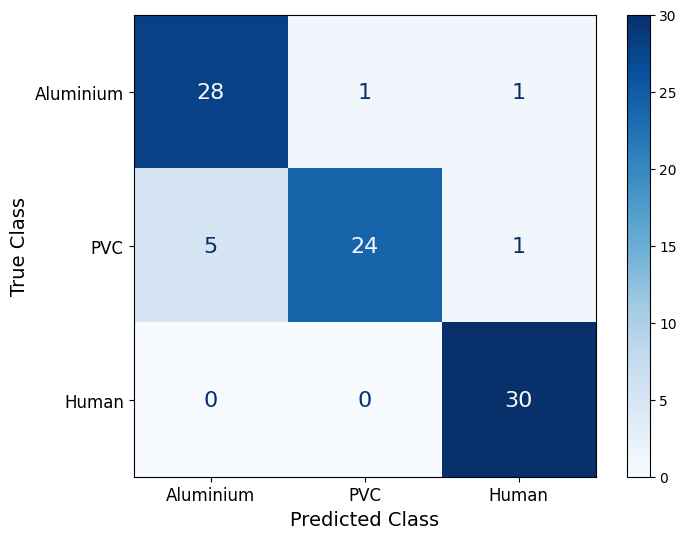

Precision for each class: [0.84848485 0.96       0.9375    ]
Weighted precision: 0.9153282828282828
Recall for each class: [0.93333333 0.8        1.        ]
Weighted recall: 0.9111111111111111
F1 score for each class: [0.88888889 0.87272727 0.96774194]
Weighted F1 score: 0.9097860323666774


In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

# Extract the true labels and predictions
true_labels = all_predictions['contact_class']
predictions = all_predictions['contact_class_prediction']

# Compute and plot confusion matrix
cm = confusion_matrix(true_labels, predictions)

class_labels = ['Aluminium', 'PVC', 'Human']
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', ax=plt.gca())

for text in cm_display.ax_.texts:
    text.set_fontsize(16)

plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Compute precision and recall
precision = precision_score(true_labels, predictions, average=None)
precision_weighted = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average=None)
recall_weighted = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average=None)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

print("Precision for each class:", precision)
print("Weighted precision:", precision_weighted)
print("Recall for each class:", recall)
print("Weighted recall:", recall_weighted)
print("F1 score for each class:", f1)
print("Weighted F1 score:", f1_weighted)